In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def pivot_k(df):
    df_exploded = df.explode('errors')
    df_exploded['k'] = df_exploded.groupby('graph_id').cumcount()

    df_wide = df_exploded.pivot(index='graph_id', columns='k', values='errors')

    df_wide.columns = [f'k_{col + 1}' for col in df_wide.columns]
    df_wide.reset_index(inplace=True)
    
    return df_wide.fillna(0)

In [3]:
def error_intervals(df, normalized=False, interval_size=0.05):
    bins = np.arange(0, 1.05, interval_size)

    df_bins = df.copy()

    columns = list(filter(lambda name: name.startswith("k"), list(df.columns)))
    
    for col in columns:
        if not normalized:
            df_col = df[col]
        else:
            k = int(col.replace("k_", ""))
            df_col = df[col][df["n_nodes"] >= k]

        df_bins[col] = pd.cut(df_col, bins, include_lowest=True)

    data = [df_bins[col].value_counts() for col in columns]
    index = df_bins["k_1"].value_counts().sort_index().index.rename("bins")

    df_error_intervals = pd.DataFrame(index=index, data=dict(zip(range(1, len(data) + 1), data)))
    df_error_intervals.index = df_error_intervals.index.rename_categories({index[0]: pd.Interval(0, 0.05, closed="both")}) # otherwise the interval starts a -0.001
    
    return df_error_intervals

In [4]:
def plot_nodes_error_k(data, k_list):
    plt.figure(figsize=(18, 9))
    for k in k_list:
        col_name = "k_" + str(k) 
        plt.errorbar(data.index, data[col_name]["mean"], yerr=data[col_name]["std"], fmt='-o', capsize=0.2, capthick=1, label=col_name)
        if len(data.index) > 200:
            plt.xticks(range(data.index.min(), data.index.max(), len(data.index) // 50), rotation=60)
        else:
            plt.xticks(data.index, rotation=60)
    plt.xlabel("Number of Nodes")
    plt.ylabel("Relative Reconstruction Error")
    plt.legend()
    plt.show()

In [36]:
def plot_percentage_per_k(df, error_interval_idx, title):
    plt.figure(figsize=(12, 6))
    for idx in sorted(error_interval_idx):
        df.iloc[idx].plot(label=df.index[idx])
    
    plt.xticks(range(1, df.columns.max(), 5), rotation=60)
    plt.title(title + " " + f"Percentage of Graphs Covered per k at Given Error")
    plt.xlabel("k")
    plt.ylabel("Percentage of Graphs")
    plt.legend()
    plt.show()

In [6]:
def plot_error_intervals_at_k(df, k):
    plt.figure(figsize=(18, 6))
    df[k].plot(kind="bar")
    plt.xlabel("Reconstruction Error Intervals")
    plt.ylabel("Percentage of Graphs")
    plt.title(f"Percentage of Graphs per Error at k={k}")
    plt.xticks(rotation=60)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.show()

In [3]:
zinc = pd.read_parquet('../../output/tsvd_out/ZINC_updated.parquet')
peptides = pd.read_parquet('../../output/tsvd_out/peptides_updated.parquet')
cifar = pd.read_parquet('../../output/tsvd_out/cifar_updated.parquet')

In [47]:
zinc

,graph_id,n_nodes,rr,errors,time
0,0,29,17,"[1.0, 0.9842509842514764, 0.9185586535436918, ...",0.033979
1,1,26,16,"[1.0, 1.0, 0.9354143466934853, 0.8864052604279...",0.024095
2,2,16,9,"[1.0, 1.0, 0.8574929257125441, 0.7071067811865...",0.023341
3,3,27,17,"[1.0, 1.0, 0.9486832980505138, 0.9309493362512...",0.027386
4,4,21,16,"[1.0112997936948631, 1.0224747162910903, 0.917...",0.022408
...,...,...,...,...,...
9995,9995,11,7,"[0.9293203772845852, 0.8528028654224417, 0.707...",0.012590
9996,9996,19,10,"[1.0, 0.9746794344808962, 0.8366600265340756, ...",0.010350
9997,9997,21,12,"[1.0, 0.9780192938436515, 0.9325048082403138, ...",0.013314
9998,9998,15,9,"[0.9309493362512626, 0.8563488385776753, 0.836...",0.009034


# Node Count Distribution

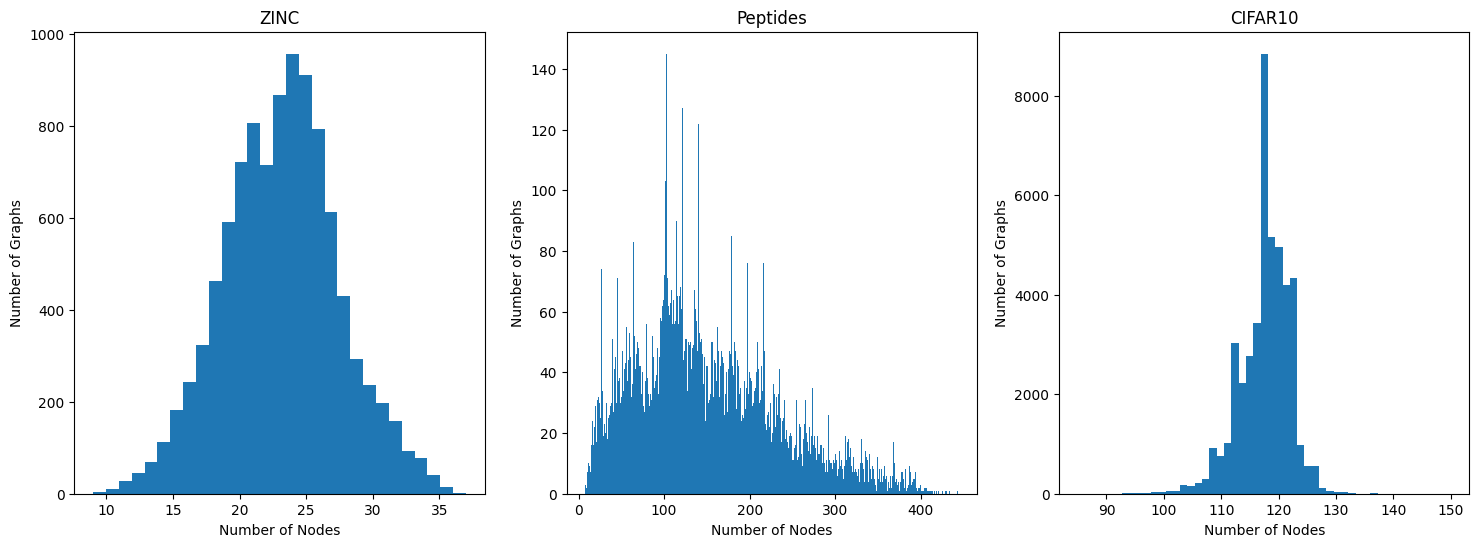

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, dataset) in enumerate(zip(["ZINC", "Peptides", "CIFAR10"], [zinc, peptides, cifar])):
    axs[idx].hist(dataset["n_nodes"], bins=len(np.unique(dataset["n_nodes"])))
    axs[idx].set_title(name)

for ax in axs.flat:
    ax.set(xlabel='Number of Nodes', ylabel='Number of Graphs')

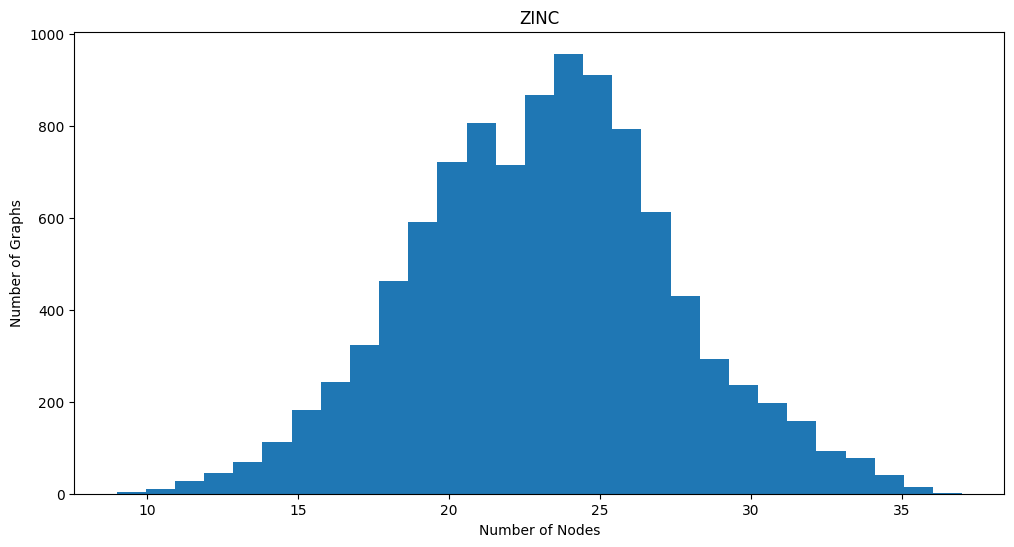

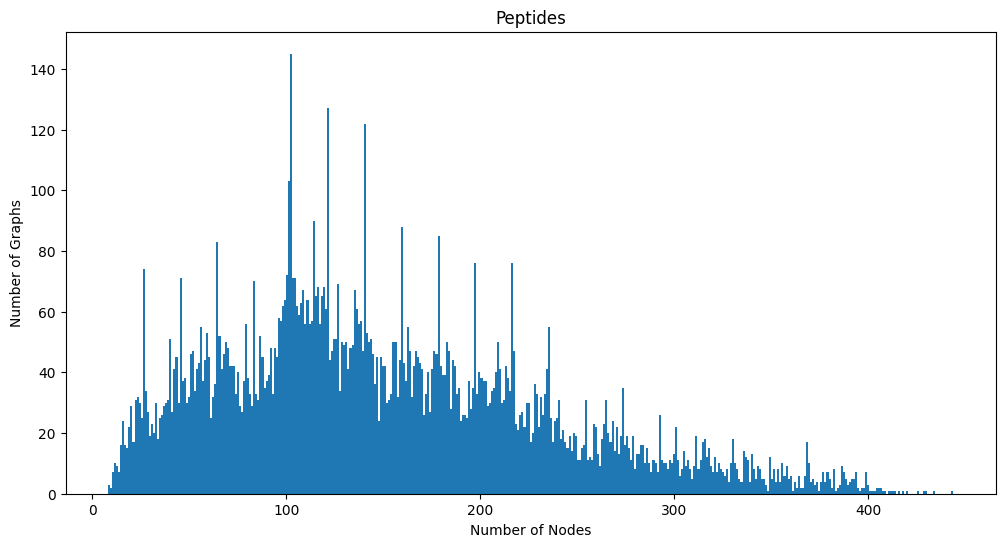

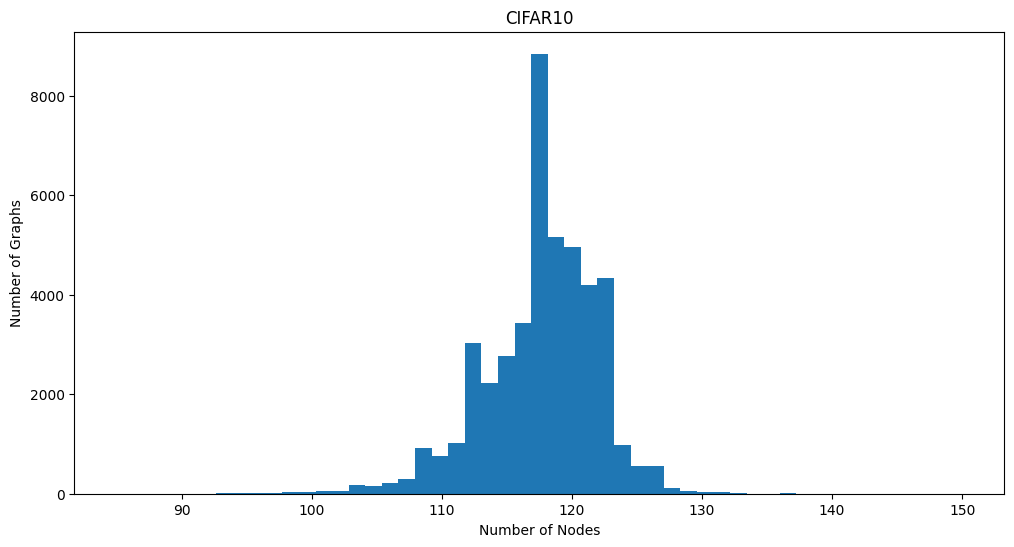

In [44]:


for idx, (name, dataset) in enumerate(zip(["ZINC", "Peptides", "CIFAR10"], [zinc, peptides, cifar])):
    plt.figure(figsize=(12, 6))
    plt.hist(dataset["n_nodes"], bins=len(np.unique(dataset["n_nodes"])))
    plt.title(name)
    plt.xlabel('Number of Nodes')
    plt.ylabel('Number of Graphs')
    plt.show()

# ZINC

In [9]:
zinc_k = pivot_k(zinc).set_index('graph_id').join(zinc.set_index('graph_id').drop('errors', axis="columns"))

/tmp/ipykernel_7737/2455897697.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df_wide.fillna(0)


In [10]:
zinc_measures = zinc_k.groupby("n_nodes").agg(['mean', 'std'])
zinc_max_k = zinc["errors"].apply(lambda errors: len(errors)).max()

In [13]:
zinc_measures.to_parquet("zinc_res_tsvd.parquet")

In [46]:
zinc_k

,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,...,k_19,k_20,k_21,k_22,k_23,k_24,k_25,n_nodes,rr,time
graph_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.984251,0.918559,0.918559,0.866025,0.728869,0.661438,0.637377,0.559017,0.530330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,17,0.033979
1,1.000000,1.000000,0.935414,0.886405,0.790569,0.731925,0.707107,0.597614,0.534522,0.462910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,16,0.024095
2,1.000000,1.000000,0.857493,0.707107,0.568796,0.485071,0.420084,0.420084,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,9,0.023341
3,1.000000,1.000000,0.948683,0.930949,0.894427,0.836660,0.707107,0.605530,0.483046,0.365148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,17,0.027386
4,1.011300,1.022475,0.917011,0.797724,0.707107,0.674200,0.543557,0.476731,0.398862,0.301511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,16,0.022408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.929320,0.852803,0.707107,0.522233,0.476731,0.426401,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,7,0.012590
9996,1.000000,0.974679,0.836660,0.707107,0.632456,0.547723,0.316228,0.316228,0.223607,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,10,0.010350
9997,1.000000,0.978019,0.932505,0.807573,0.625543,0.659380,0.510754,0.417029,0.294884,0.208514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,12,0.013314


## Error node counts

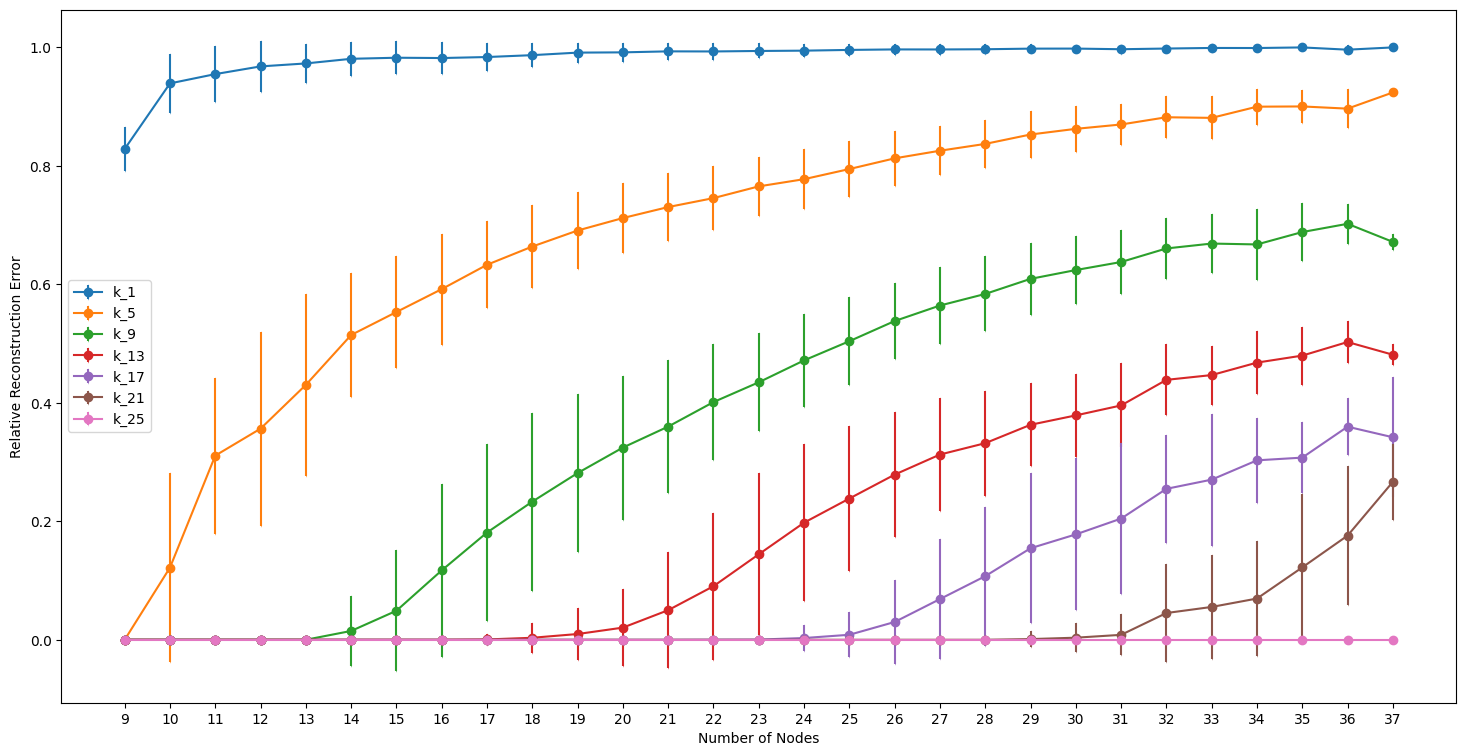

In [155]:
plot_nodes_error_k(zinc_measures, range(1, zinc_max_k + 4, 4))

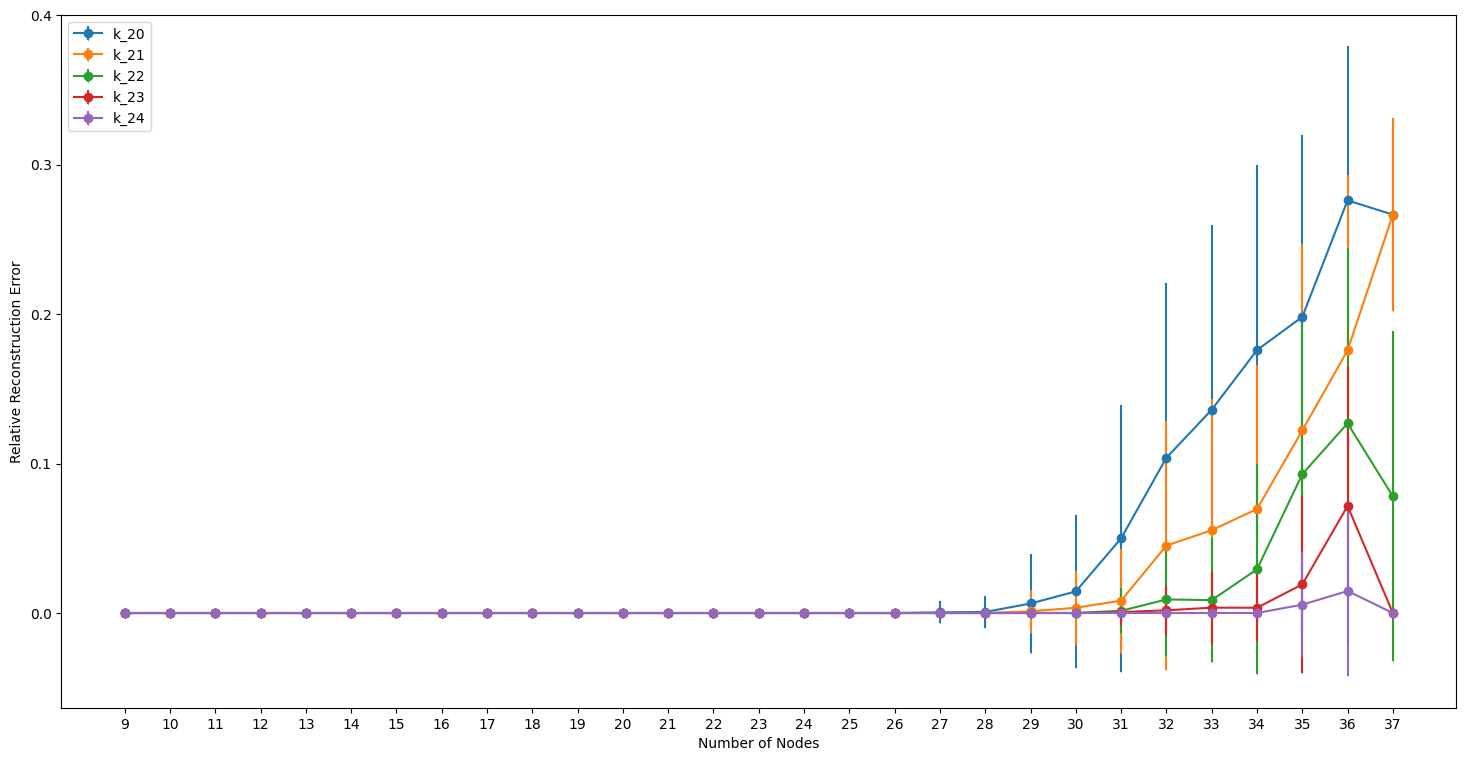

In [157]:
plot_nodes_error_k(zinc_measures, range(20, 25))

## Error intervals

In [45]:
zinc_error = error_intervals(zinc_k)

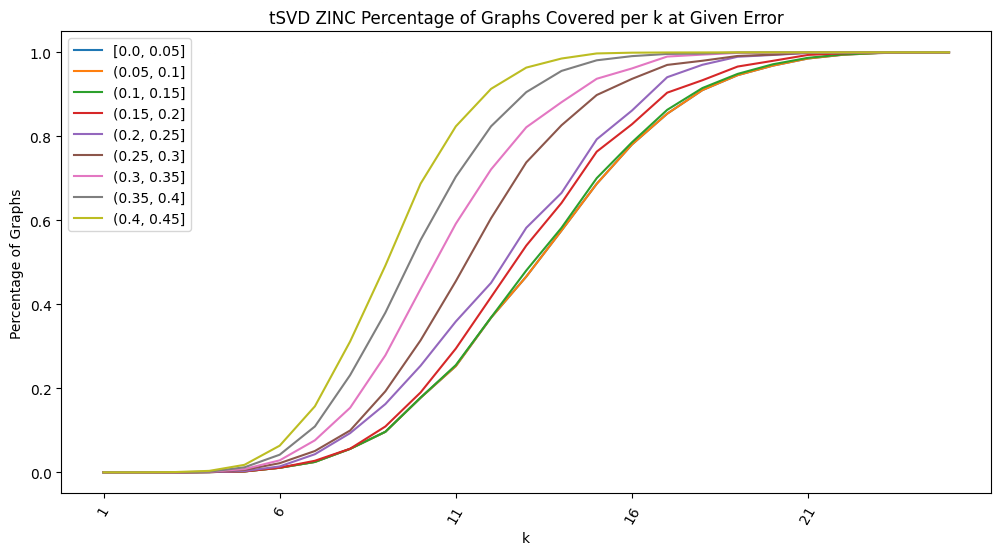

In [39]:
plot_percentage_per_k(zinc_error.cumsum() / zinc_error.sum(), range(0, 9), "tSVD ZINC")

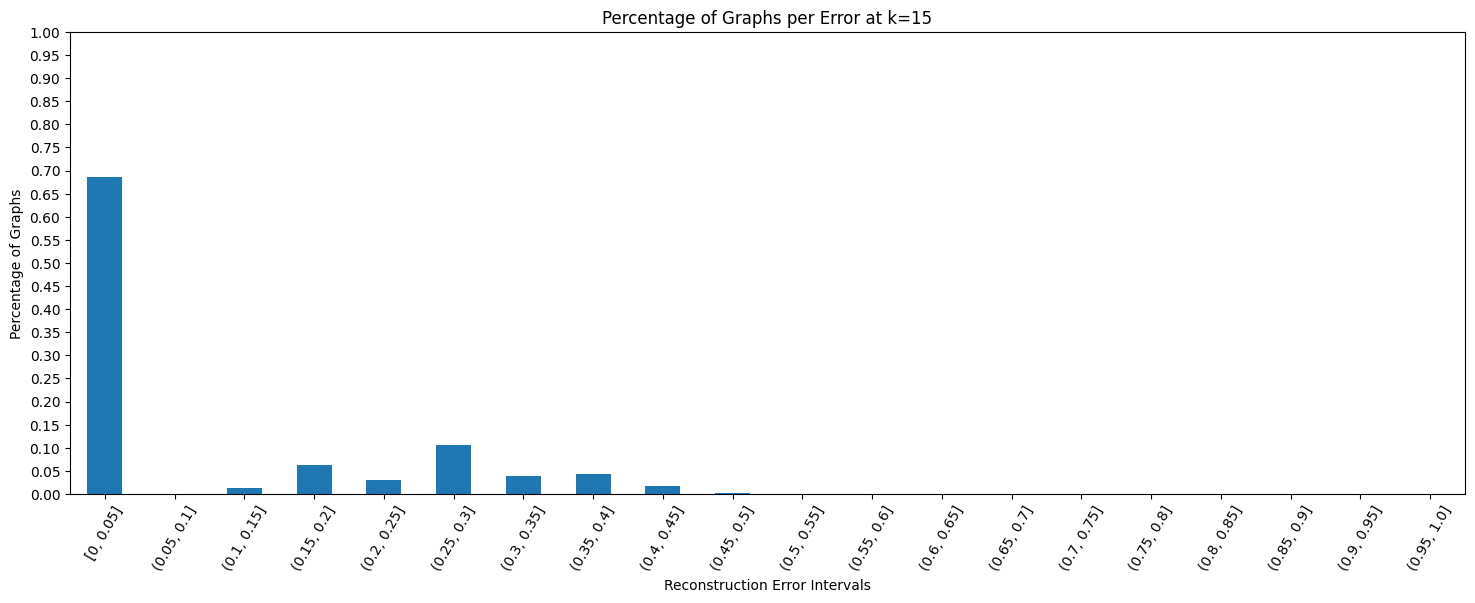

In [413]:
plot_error_intervals_at_k(zinc_error / zinc_error.sum(), 15)

# Peptides

In [17]:
peptides.iloc[0]

graph_id                                                    0
n_nodes                                                   338
rr                                                        191
errors      [1.0, 1.0, 1.0, 0.9970631360955552, 0.99706313...
time                                                14.881416
Name: 0, dtype: object

In [18]:
peptides_k = pivot_k(peptides).set_index('graph_id').join(peptides.set_index('graph_id').drop('errors', axis="columns"))

/tmp/ipykernel_7737/2455897697.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df_wide.fillna(0)


## Error node count

In [19]:
peptides_measures = peptides_k.groupby("n_nodes").agg(['mean', 'std'])
peptides_max_k = peptides["errors"].apply(lambda errors: len(errors)).max()

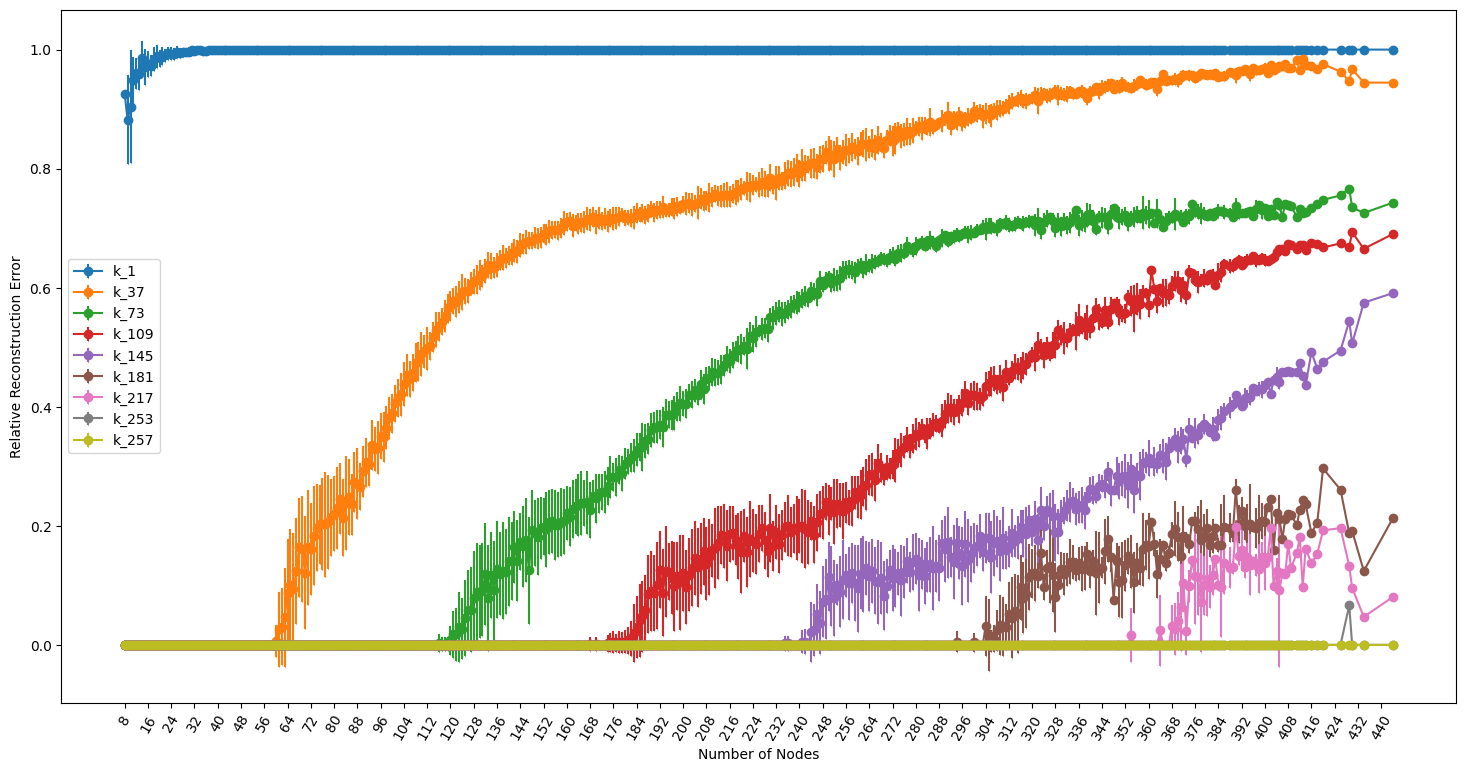

In [20]:
plot_nodes_error_k(peptides_measures, list(range(1, peptides_max_k, peptides_max_k // 7)) + [peptides_max_k])

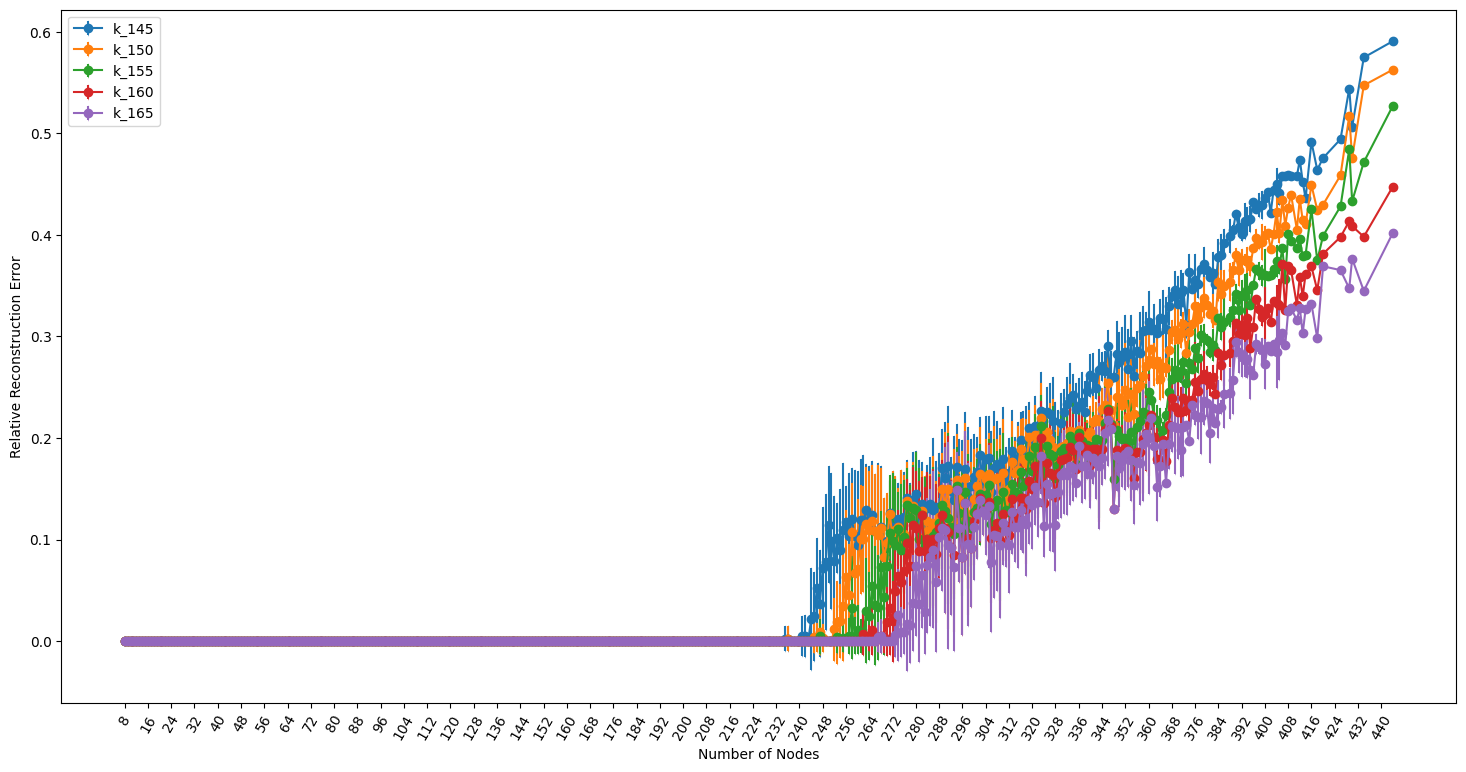

In [21]:
plot_nodes_error_k(peptides_measures, range(145, 170, 5))

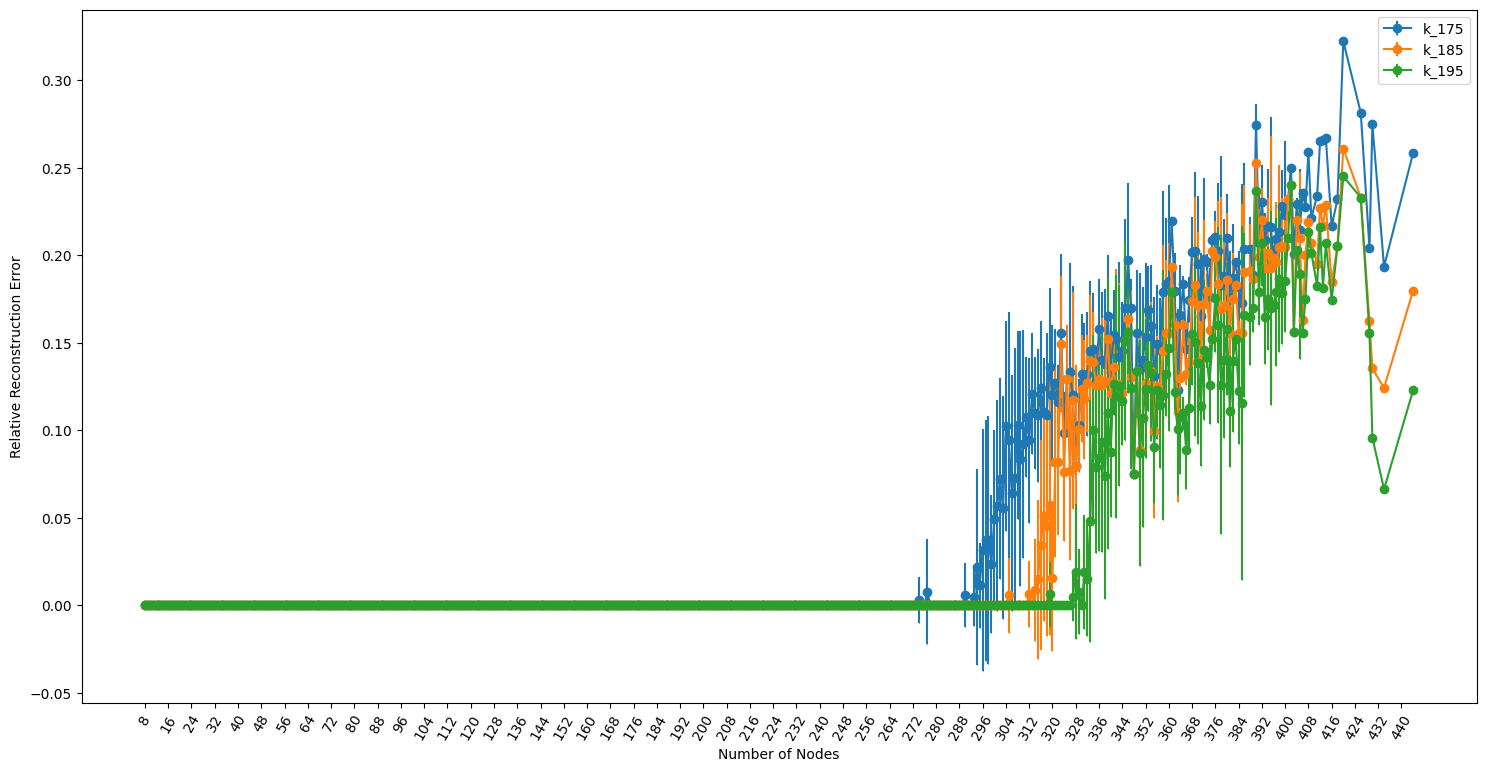

In [22]:
plot_nodes_error_k(peptides_measures, range(175, 205, 10))

## Error intervals

In [23]:
peptides_error = error_intervals(peptides_k)

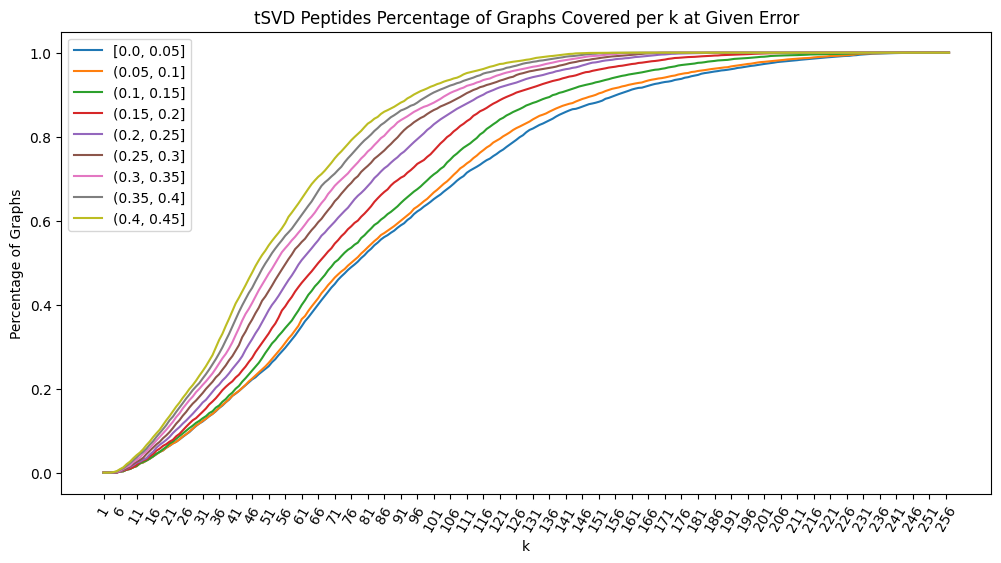

In [37]:
plot_percentage_per_k(peptides_error.cumsum() / peptides_error.sum(), range(0, 9), "tSVD Peptides")

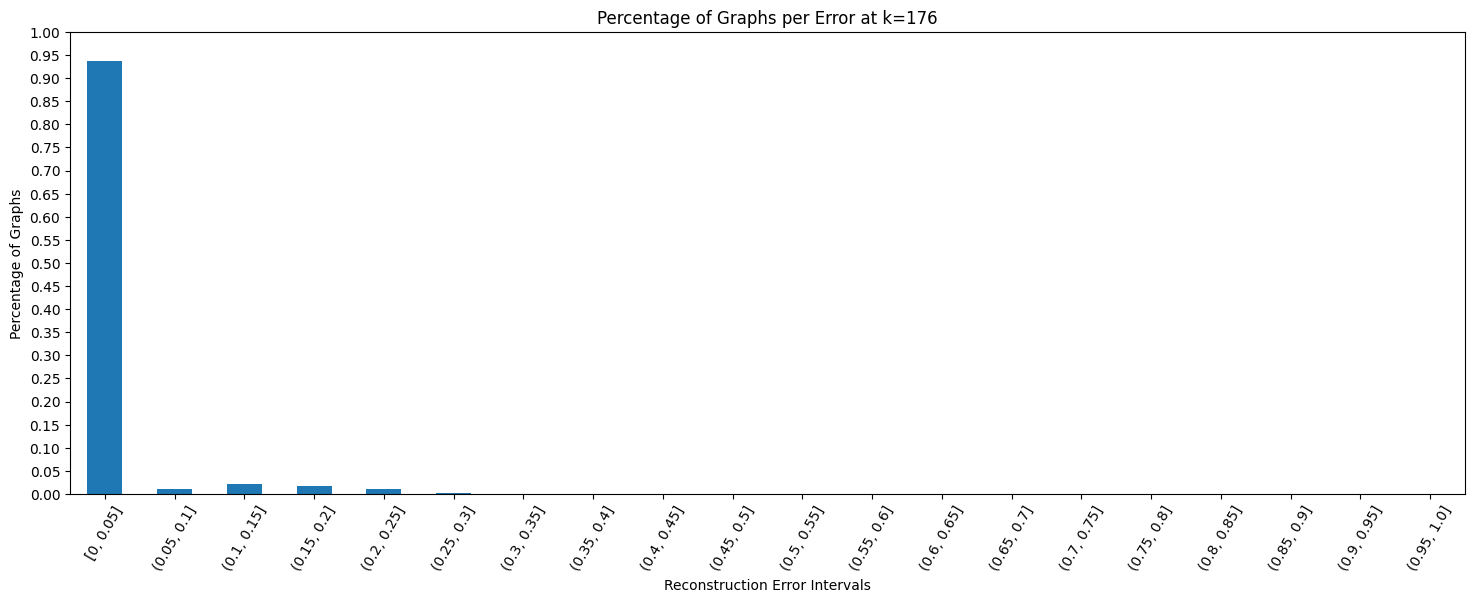

In [404]:
plot_error_intervals_at_k(peptides_error / peptides_error.sum(), 176)

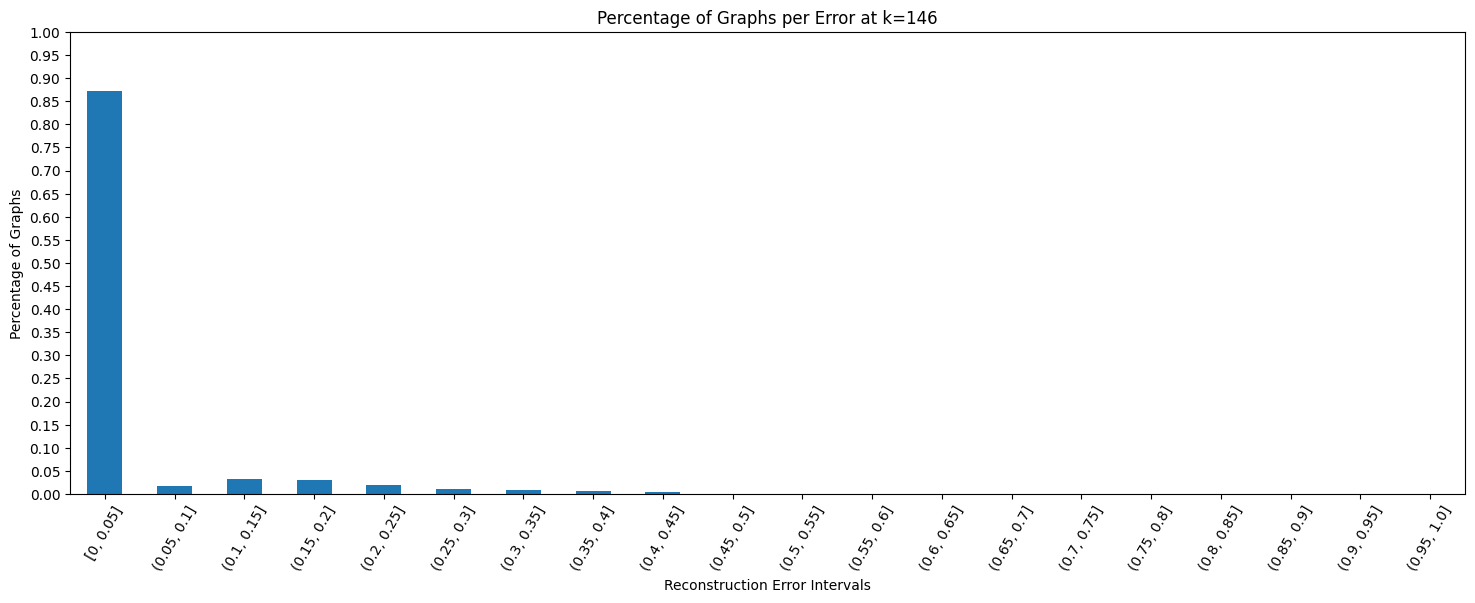

In [405]:
plot_error_intervals_at_k(peptides_error / peptides_error.sum(), 146)

# CIFAR10

In [25]:
cifar_k = pivot_k(cifar).set_index('graph_id').join(cifar.set_index('graph_id').drop('errors', axis="columns"))

/tmp/ipykernel_7737/2455897697.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df_wide.fillna(0)


## Error node count

In [26]:
cifar_measures = cifar_k.groupby("n_nodes").agg(['mean', 'std'])
cifar_max_k = cifar["errors"].apply(lambda errors: len(errors)).max()

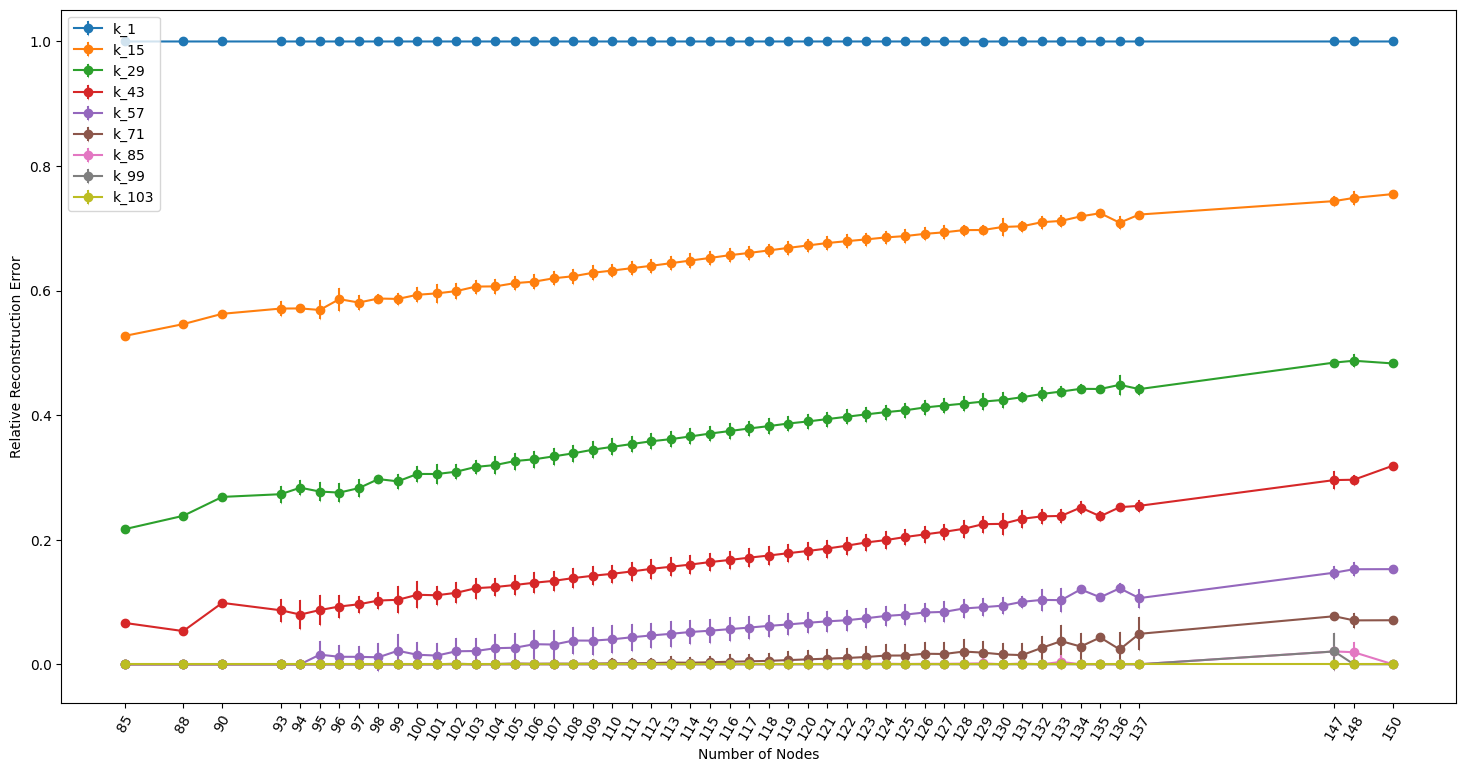

In [27]:
plot_nodes_error_k(cifar_measures, list(range(1, cifar_max_k, cifar_max_k // 7)) + [cifar_max_k])

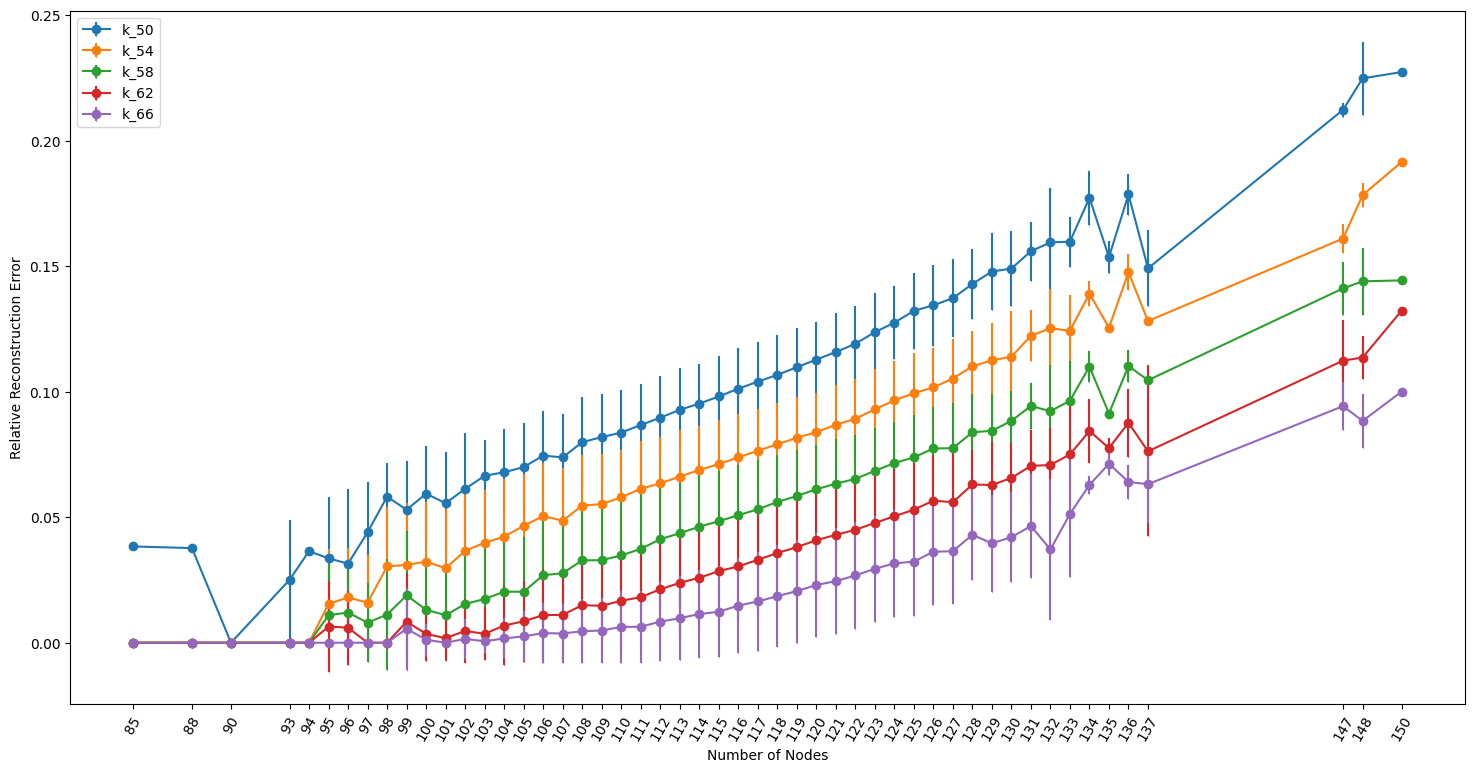

In [28]:
plot_nodes_error_k(cifar_measures, range(50, 70, 4))

## Error intervals

In [29]:
cifar_error = error_intervals(cifar_k)

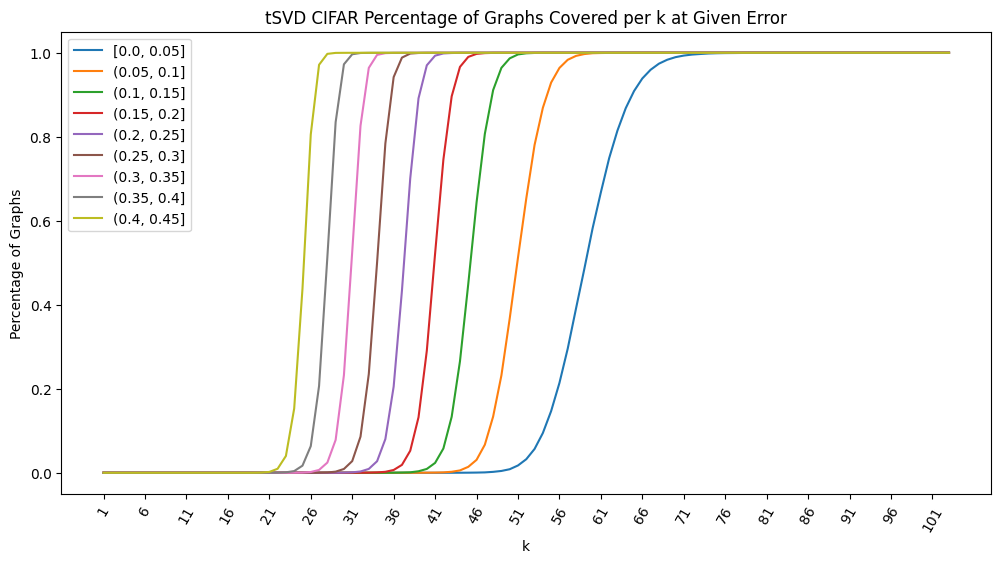

In [38]:
plot_percentage_per_k(cifar_error.cumsum() / cifar_error.sum(), range(0, 9), "tSVD CIFAR")

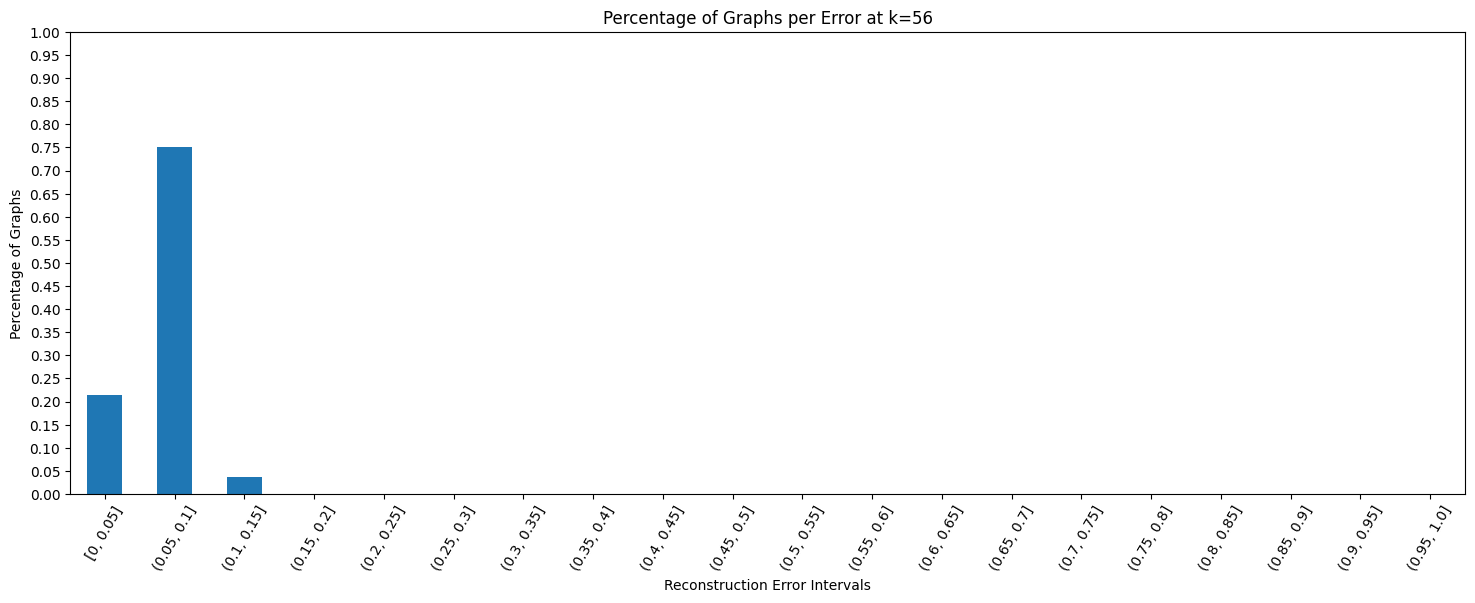

In [408]:
plot_error_intervals_at_k(cifar_error / cifar_error.sum(), 56)

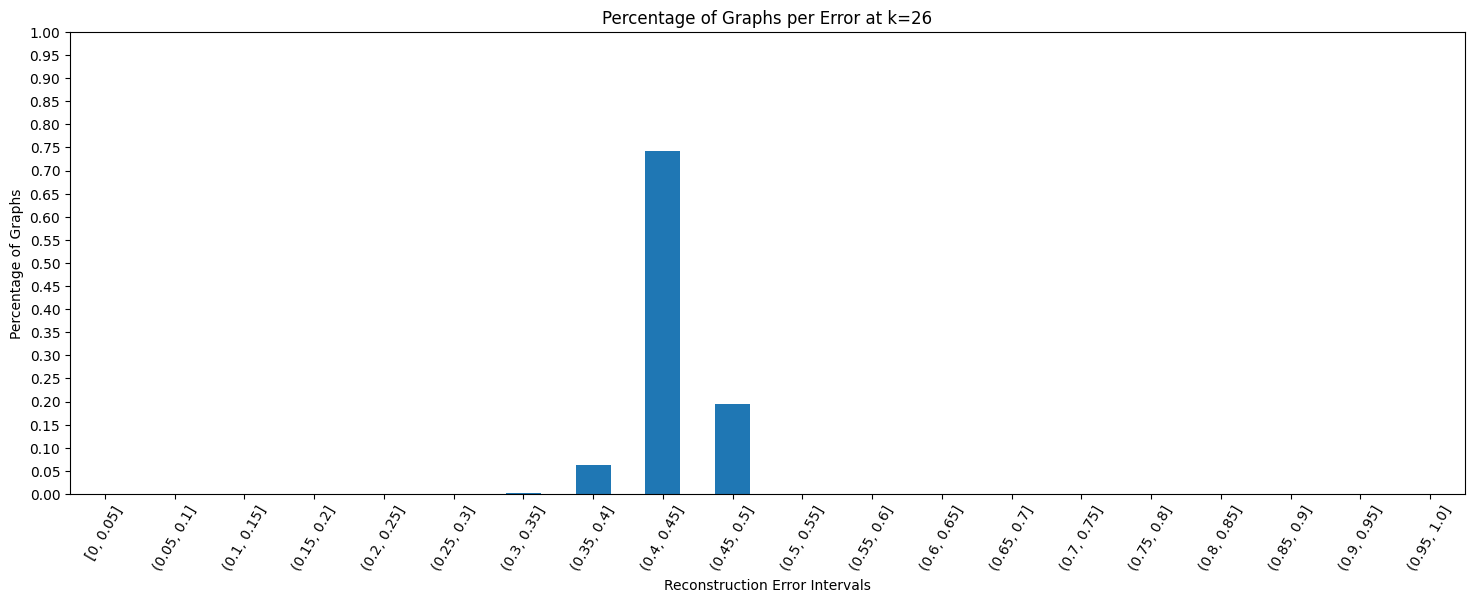

In [409]:
plot_error_intervals_at_k(cifar_error / cifar_error.sum(), 26)

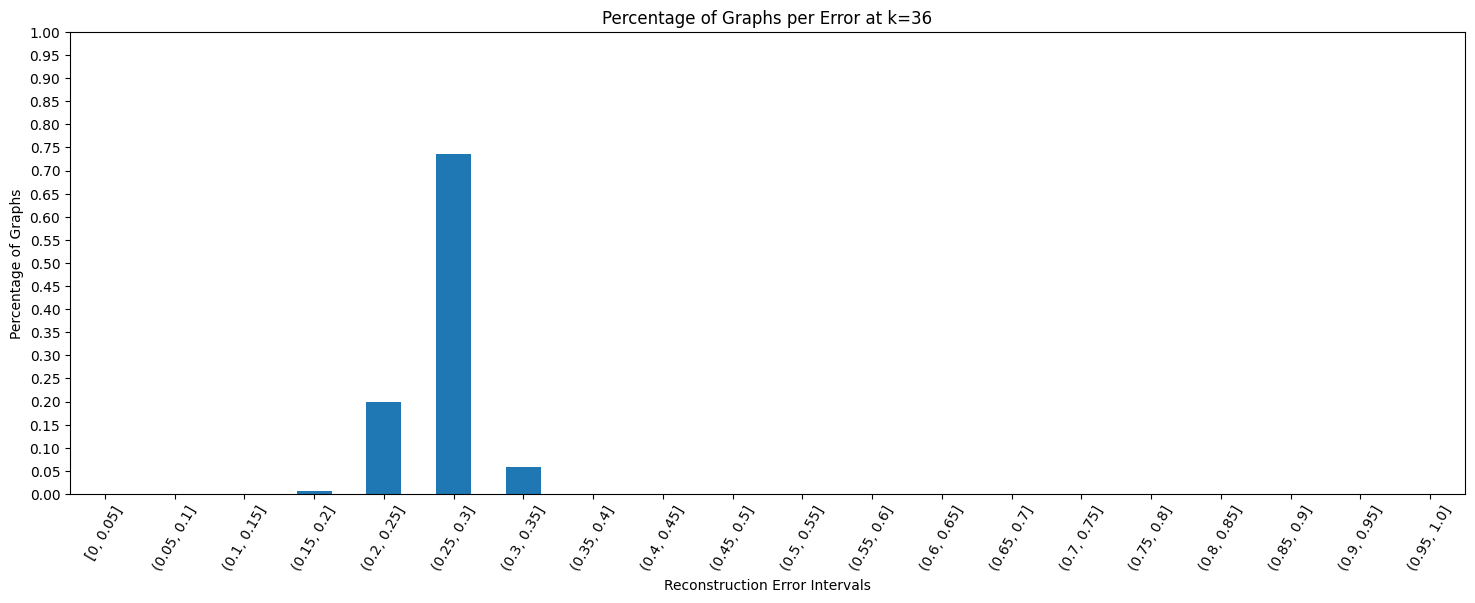

In [410]:
plot_error_intervals_at_k(cifar_error / cifar_error.sum(), 36)